# Conditional Neural Processes (CNP) for Coherent.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter
import shap
import yaml
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
try:
    from resum.conditional_neural_process import DeterministicModel
    from resum.conditional_neural_process import DataGeneration
except Exception as e:
    print(f"Error occurred: {e}. Retrying import...")
    from resum.conditional_neural_process import DeterministicModel
    from resum.conditional_neural_process import DataGeneration


IPython could not be loaded!


In [2]:
with open("../coherent/settings_newdata.yaml", "r") as f:
    config_file = yaml.safe_load(f)

TRAINING_EPOCHS = int(config_file["cnp_settings"]["training_epochs"]) # Total number of training points: training_iterations * batch_size * max_content_points
PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
BATCH_SIZE = config_file["cnp_settings"]["batch_size_train"]
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_train"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out = config_file["path_settings"]["path_out_cnp"]
version = config_file["path_settings"]["version"]

In [3]:
x_size, y_size = utils.get_feature_and_label_size(config_file)

Data Augmentation in Progress: Applying transformations...


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


2025-07-29 01:23:52 Iteration: 0/0, train loss: 0.7835 (vs BCE 0.7052)
2025-07-29 01:23:52, Iteration: 0, test loss: 0.8311 (vs BCE 0.7165)


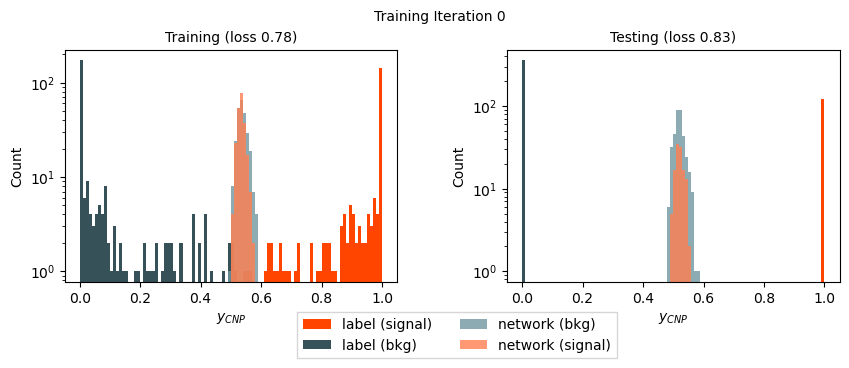

2025-07-29 01:33:12 Iteration: 0/1000, train loss: 0.6688 (vs BCE 0.4767)
2025-07-29 01:33:12, Iteration: 1000, test loss: 0.6903 (vs BCE 0.4097)


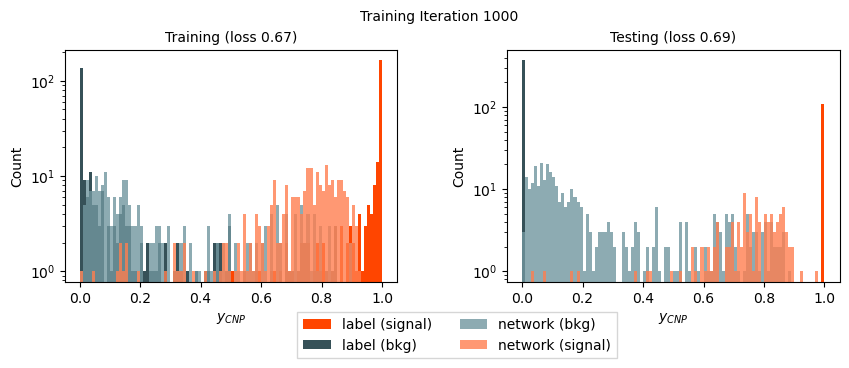



Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


2025-07-29 01:42:15 Iteration: 1/2000, train loss: 0.6762 (vs BCE 0.4805)
2025-07-29 01:42:15, Iteration: 2000, test loss: 0.6927 (vs BCE 0.4075)


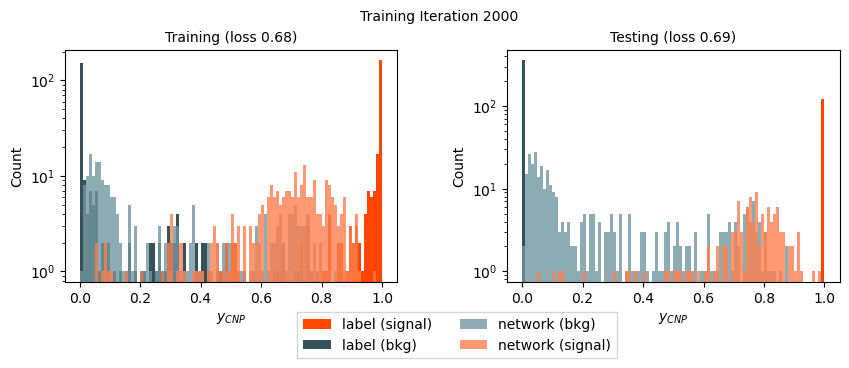

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


2025-07-29 01:51:20 Iteration: 2/3000, train loss: 0.6641 (vs BCE 0.4687)
2025-07-29 01:51:20, Iteration: 3000, test loss: 0.6754 (vs BCE 0.3638)


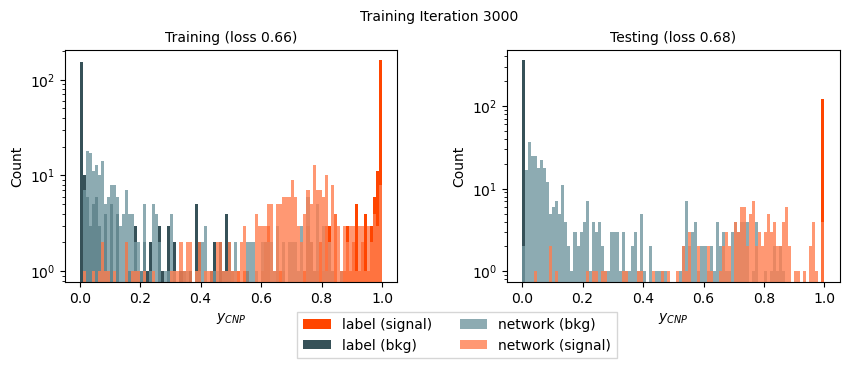

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


2025-07-29 02:00:22 Iteration: 3/4000, train loss: 0.6461 (vs BCE 0.4288)
2025-07-29 02:00:22, Iteration: 4000, test loss: 0.6698 (vs BCE 0.3540)


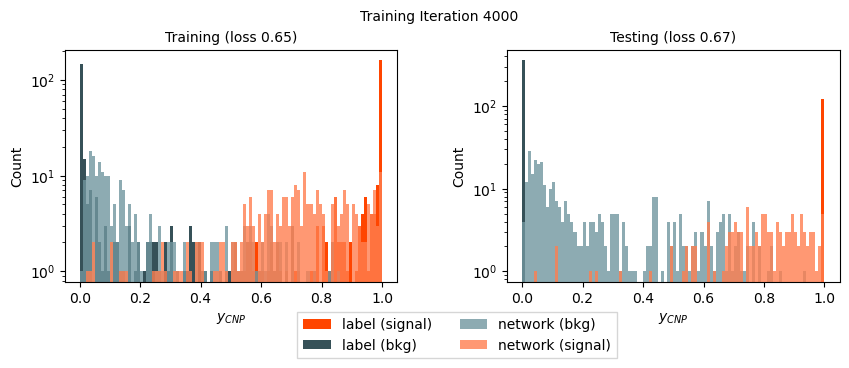

KeyboardInterrupt: 

In [4]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size*2
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes, decoder_sizes)
writer = SummaryWriter(log_dir=f'{path_out}/cnp_{version}_tensorboard_logs')

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0
for it_epoch in range(TRAINING_EPOCHS):
    
    USE_DATA_AUGMENTATION = config_file["cnp_settings"]["use_data_augmentation"]
    # load data:
    dataset_train = DataGeneration(mode = "training", 
                                   config_file=config_file, 
                                   path_to_files=config_file["path_settings"]["path_to_files_train"], 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=BATCH_SIZE,
                                   files_per_batch=FILES_PER_BATCH)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader

    dataset_test = DataGeneration(mode = "training", 
                                  config_file=config_file, 
                                  path_to_files=config_file["path_settings"]["path_to_files_train"], 
                                  use_data_augmentation=False, 
                                  batch_size=BATCH_SIZE,
                                  files_per_batch=FILES_PER_BATCH)
    dataset_test.set_loader()
    dataloader_test = dataset_test.dataloader
    data_iter = iter(dataloader_test)

    #it_batch = 0
    
    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, _ = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()
    
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1
        
        # Inside your batch loop, right after computing losses:
        writer.add_scalar('Loss/train_logprob', loss.item(), it_batch)
        if is_binary:
            writer.add_scalar('Loss/train_BCE', loss_bce.item(), it_batch)

        
        mu=mu[0].detach().numpy()
        
        if it_batch % PLOT_AFTER == 0:
            batch_testing = next(data_iter)
            batch_formated_test=dataset_test.format_batch_for_cnp(batch_testing,config_file["cnp_settings"]["context_is_subset"] )
          
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it_epoch, it_batch,loss, loss_bce))
            
            writer.add_scalar('Loss/train_logprob', loss.item(), iter_testing)
            if is_binary:
                writer.add_scalar('Loss/train_BCE', loss_bce.item(), iter_testing)

            log_prob_testing, mu_testing, _ = model(batch_formated_test.query, batch_formated_test.target_y, is_binary)
            loss_testing = -log_prob_testing.mean()
            

            if is_binary:
                loss_bce_testing = bce(mu_testing,  batch_formated_test.target_y)
            else:
                loss_bce_testing = -1.

            writer.add_scalar('Loss/test_logprob', loss_testing.item(), test_idx)
            if is_binary:
                writer.add_scalar('Loss/test_BCE', loss_bce_testing.item(), test_idx)

            mu_testing = mu_testing[0].detach().numpy()
            print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it_batch, loss_testing, loss_bce_testing))
            if y_size ==1:
                fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated_test.target_y[0].detach().numpy(), f'{loss_testing:.2f}', target_range, it_batch)
                writer.add_figure('Prediction/train_vs_test', fig, global_step=test_idx)
            else:
                for k in range(y_size):
                    fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated_test.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', target_range, it_batch)
                    writer.add_figure(f'Prediction/train_vs_test_k{k}', fig, global_step=test_idx)
            test_idx+=1
    
        it_batch+=1

writer.close()
torch.save(model.state_dict(), f'{path_out}/cnp_{version}_model_20epochs.pth')